In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from plotnine import *

In [14]:
case = pd.read_csv('china_covid_cases_2021_22.csv')
case['date'] = pd.to_datetime(case['date'])
case.head()

,date,total,import,local
0,2022-12-07,4079,48,4031
1,2022-12-06,4409,58,4351
2,2022-12-05,5046,58,4988
3,2022-12-04,4318,71,4247
4,2022-12-03,4213,45,4168


# 1. Cases by day

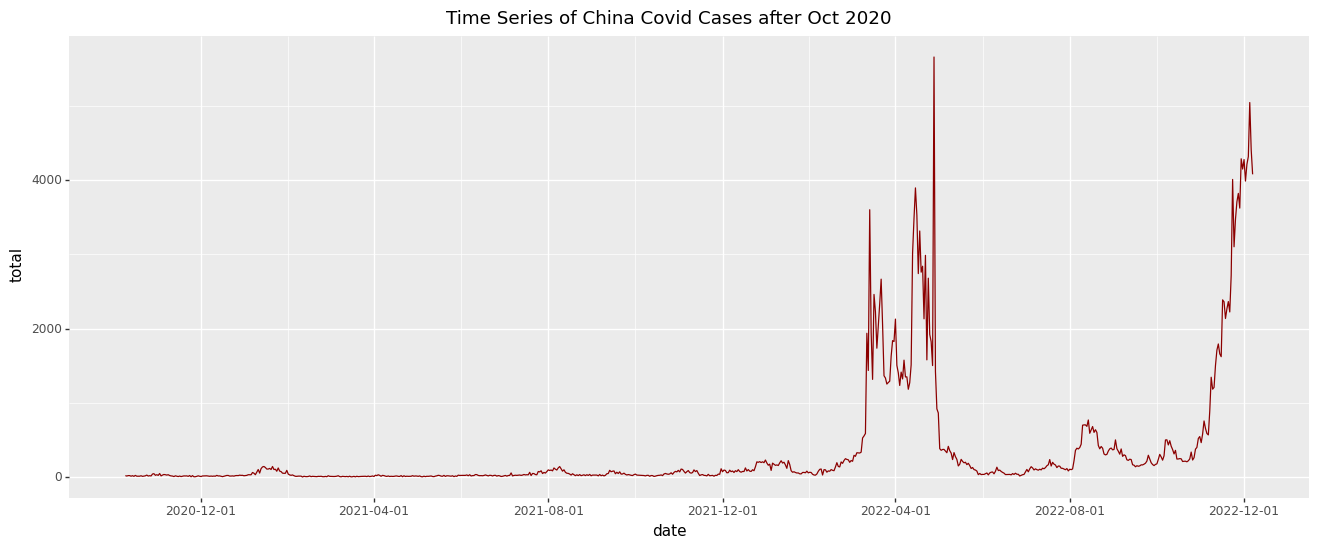

<ggplot: (121404473107)>

In [15]:
ggplot(case, aes(x = 'date')) + geom_line(aes(y='total'), color = 'darkred') + ggtitle("Time Series of China Covid Cases after Oct 2020") + scale_x_date(date_breaks='4 months') + theme(figure_size=(16, 6))

According to the time series plot, we can roughly divide the data into three part to analysis:
1. `zero` Before 2022. This was when China's zero-covid policy took effect.
2. `spring` Spring 2022 (Feb to May). This was a wave of covid in Shanghai.
3. `winter` Winter 2022 (late Oct to now). This is a nation-wide wave of covid happening now and China is turning from zero-covid policy to "live with covid" policy.
We will analyse these three data separately or together to gain some insights.

In [16]:
zero = case[case['date'] < '2022-01-01'].reset_index().drop(columns='index')

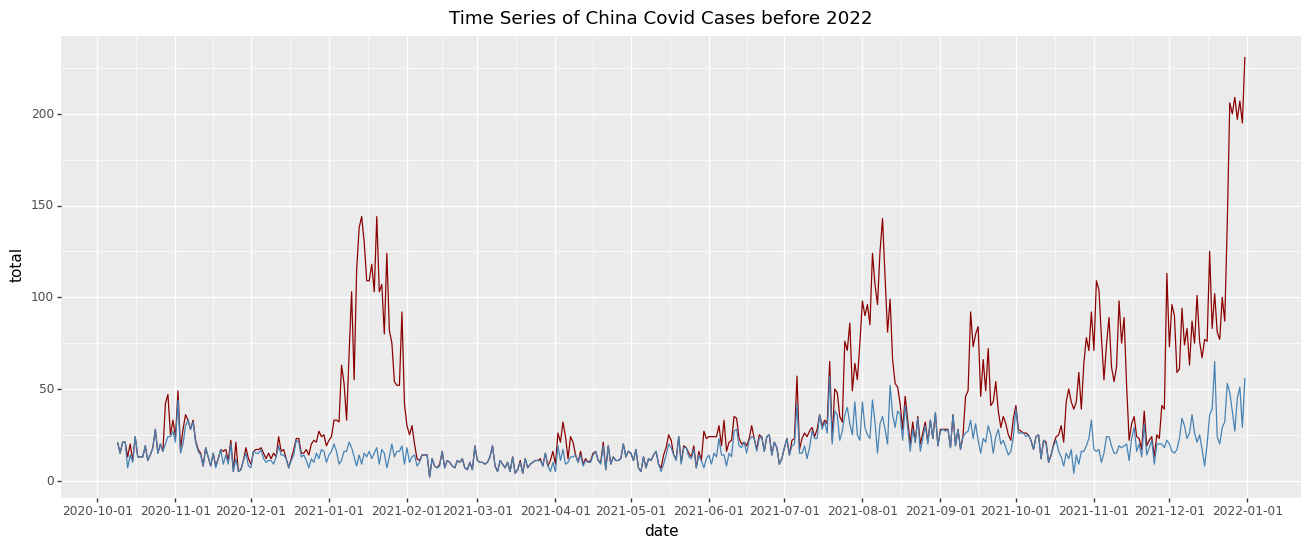

<ggplot: (121404455048)>

In [46]:
ggplot(zero, aes(x = 'date')) + geom_line(aes(y='total'), color = 'darkred') + geom_line(aes(y='import'), color='steelblue') + ggtitle("Time Series of China Covid Cases before 2022") + scale_x_date(date_breaks='1 month') + theme(figure_size=(16, 6))

In [18]:
spring = case.loc[(case['date'] > '2022-3-1') & (case['date'] < '2022-5-10')].reset_index().drop(columns='index')

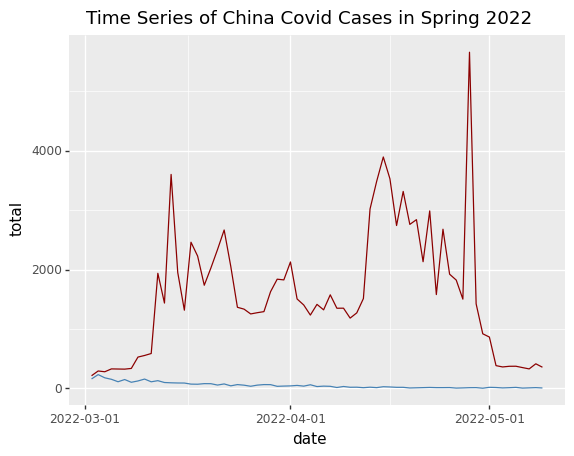

<ggplot: (121405396986)>

In [19]:
ggplot(spring, aes(x = 'date')) + geom_line(aes(y='total'), color = 'darkred') + geom_line(aes(y='import'), color='steelblue') + ggtitle("Time Series of China Covid Cases in Spring 2022") + scale_x_date(date_breaks='1 month')

In [20]:
winter = case.loc[(case['date'] > '2022-10-22')].reset_index().drop(columns='index')

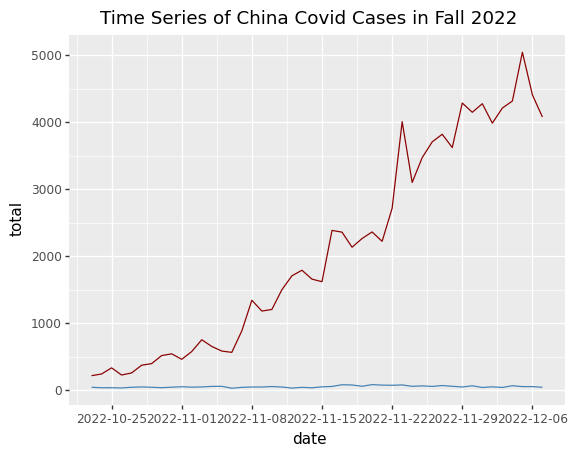

<ggplot: (121404807775)>

In [21]:
ggplot(winter, aes(x = 'date')) + geom_line(aes(y='total'), color = 'darkred') + geom_line(aes(y='import'), color='steelblue') + ggtitle("Time Series of China Covid Cases in Fall 2022") + scale_x_date(date_breaks='1 week')

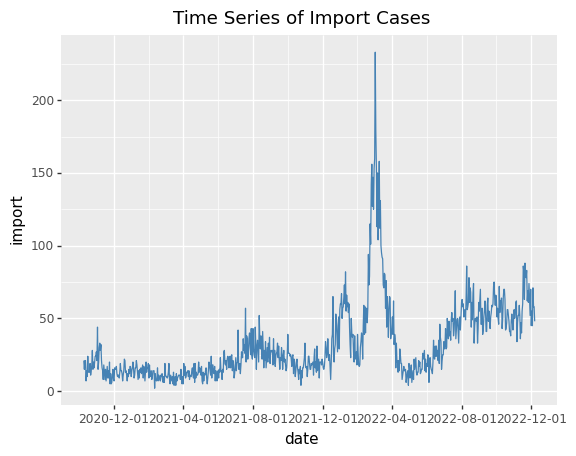

<ggplot: (121405427637)>

In [22]:
ggplot(case, aes(x = 'date')) + geom_line(aes(y='import'), color='steelblue') + ggtitle("Time Series of Import Cases") + scale_x_date(date_breaks='4 months') + theme(figure_size=(16, 6))

# 2. Cases by month

In [23]:
case['year'] = case['date'].dt.year
case['month'] = case['date'].dt.month
case['dayofweek'] = case['date'].dt.dayofweek
case.head()

,date,total,import,local,year,month,dayofweek
0,2022-12-07,4079,48,4031,2022,12,2
1,2022-12-06,4409,58,4351,2022,12,1
2,2022-12-05,5046,58,4988,2022,12,0
3,2022-12-04,4318,71,4247,2022,12,6
4,2022-12-03,4213,45,4168,2022,12,5


In [24]:
case_month = case.groupby(['year', 'month']).mean()[['total', 'import', 'local']].reset_index()
case_month.head()

,year,month,total,import,local
0,2020,10,20.565217,17.739130,2.826087
1,2020,11,18.166667,16.200000,1.966667
2,2020,12,17.064516,13.129032,3.935484
3,2021,1,80.419355,14.322581,66.096774
4,2021,2,12.428571,10.428571,2.000000


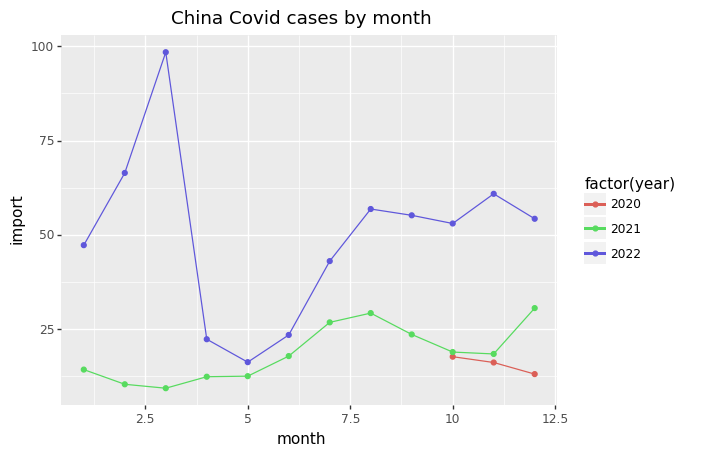

<ggplot: (121406184740)>

In [25]:
ggplot(case_month, aes('month', 'import', group='year')) + ggtitle('China Covid cases by month') + geom_line(aes(color = 'factor(year)')) + geom_point(aes(color='factor(year)'))

# 3. Cases by day of the week

We are going to check the day of the week effect
Hypotheses for the day of the week effect.
1. There are more cases in the weekends.The covid case increase are related to day of the week. For example, in weekend, people might tend to hang out together.
2. There are more cases in the weekdays. There's a statistics error pattern related to day of the week. For example, there are fewer testing staff during weekend, resulting in fewer cases detected.

In [26]:
case_dow = case.groupby(['dayofweek']).mean()[['total','import','local']]
case_dow.sort_values(by=['local'])

,total,import,local
dayofweek,,,
5,321.097345,32.247788,288.849558
6,324.345133,32.539823,291.805310
4,335.008850,32.973451,302.026549
1,339.964602,29.238938,310.725664
0,344.619469,32.300885,312.318584
2,354.955752,29.964602,324.991150
3,359.303571,32.535714,326.767857


The local cases on Saturday and Sunday do appear fewer than other days. We can use a T-test to see if the difference is statistically significant

# 4. T-test: If local cases on the weekend are significant fewer than those on weekdays (Day of the week effect)

In [27]:
def check_weekday(row):
  if row['dayofweek'] in range(0,5):
    return 'weekdays'
  elif row['dayofweek'] in [5, 6]:
    return 'weekends'

In [28]:
case['day'] = case.apply(lambda row:check_weekday(row), axis=1) # 0 means Monday
case.head()

,date,total,import,local,year,month,dayofweek,day
0,2022-12-07,4079,48,4031,2022,12,2,weekdays
1,2022-12-06,4409,58,4351,2022,12,1,weekdays
2,2022-12-05,5046,58,4988,2022,12,0,weekdays
3,2022-12-04,4318,71,4247,2022,12,6,weekends
4,2022-12-03,4213,45,4168,2022,12,5,weekends


In [29]:
from scipy import stats

In [30]:
stats.ttest_ind(case[case['day']=='weekdays']['local'], case[case['day']=='weekends']['local'])

Ttest_indResult(statistic=0.40716330762369735, pvalue=0.683998625000753)

pvalue is not less than 0.05, we cannot reject the null hypothesis of "there is no difference in weekdays and weekends".
The local cases on the weekend are the same as those on weekdays.

# 5. Relationship between imported cases and local cases

[Text(0.5, 1.0, 'Relationship between imported and local cases, China, 2021')]

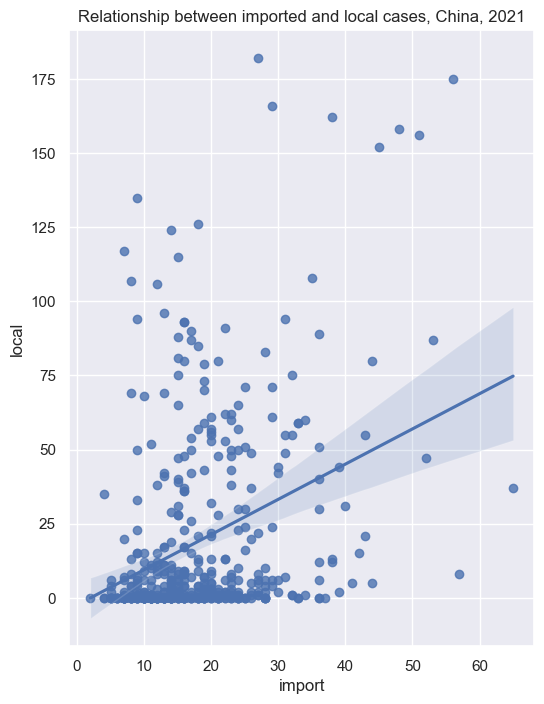

In [55]:
sns.regplot(zero, x='import', y='local').set(title='Relationship between imported and local cases, China, 2021')

[Text(0.5, 1.0, 'Relationship between import and local cases, Spring 2022')]

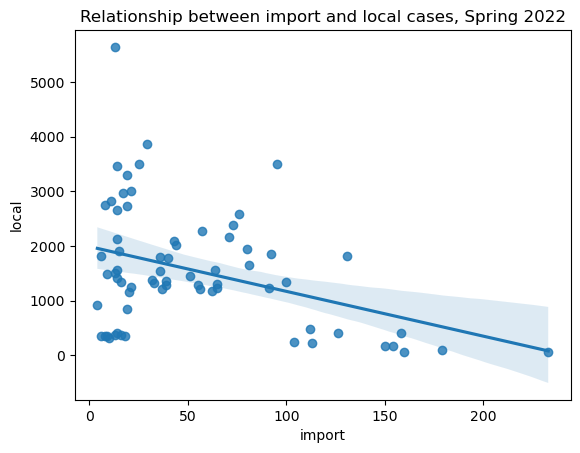

In [32]:
sns.regplot(spring, x='import', y='local').set(title='Relationship between imported and local cases, China, Spring 2022')

[Text(0.5, 1.0, 'Relationship between imported and local COVID cases, China, Winter 2022')]

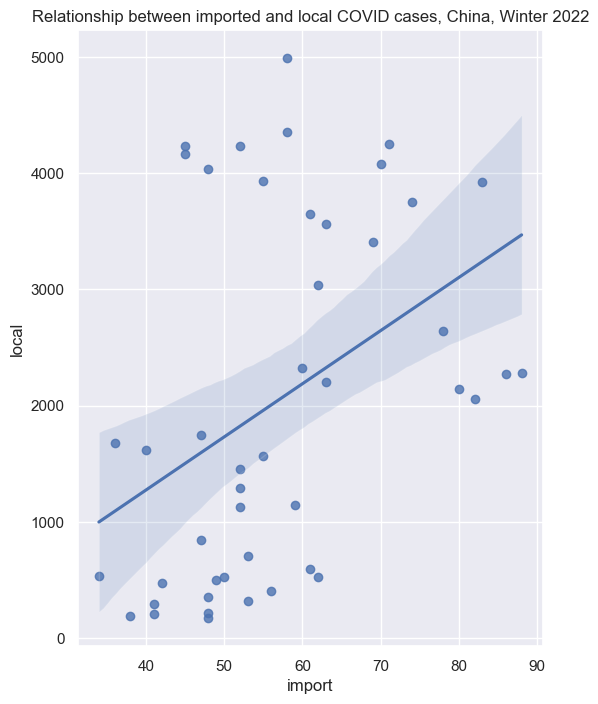

In [56]:
sns.regplot(winter, x='import', y='local').set(title='Relationship between imported and local COVID cases, China, Winter 2022')

From the plots above, we can see that in 2021 and winter 2022, there is a positive relationship between import and local cases, indicating the possibility that more import cases will result in more local cases.
However, in the wave of spring 2022, there is a negative relationship between import and local cases. I don't know the reason why.

# 6. Linear Regression Model: relationship between new covid cases - month in 2022

In [34]:
import statsmodels.formula.api as smf

In [35]:
countries_month = pd.read_csv('countries_covid_case_2022.csv')
countries_month.head()

,month,location,new_cases
0,1,China,4901
1,1,Hong Kong,1548
2,1,India,6607920
3,1,Japan,1010419
4,1,Singapore,73406


In [36]:
model1 = smf.ols('new_cases ~ C(month)', data=countries_month).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.7045
Date:                Thu, 08 Dec 2022   Prob (F-statistic):              0.731
Time:                        10:24:21   Log-Likelihood:                -1488.2
No. Observations:                  95   AIC:                             3000.
Df Residuals:                      83   BIC:                             3031.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.133e+06   6.22e+05      1.821      0.072   -1.04e+05    2.37e+06
C(month)[T.2]   2.071e+05   8.52e+05      0.243      0.808   -1.49e+06     1.9e+06
C(month)[T.3]   6.361e+05   8.52e+05      0.747      0.457   -1.06e+06    2.33e+06
C(month)[T.4]  -2.157e+05   8.52e+05     -0.253      0.801   -1.91e+06    1.48e+06
C(month)[T.5]  -2.745e+05   8.52e+05     -0.322      0.748   -1.97e+06    1.42e+06
C(month)[T.6]  -3.455e+05   8.52e+05     -0.406      0.686   -2.04e+06    1.35e+06
C(month)[T.7]   1.633e+05   8.52e+05      0.192      0.848   -1.53e+06    1.86e+06
C(month)[T.8]   6.605e+05   8.52e+05      0.776      0.440   -1.03e+06    2.35e+06
C(month)[T.9]  -2.246e+05   8.52e+05     -0.264      0.793   -1.92e+06    1.47e+06
C(month)[T.10] -5.476e+05   8.52e+05     -0.643      0.522   -2.24e+06    1.15e+06
C(month)[T.11] -2.844e+05   8.52e+05     -0.334      0.739   -1.98e+06    1.41e+06
C(month)[T.12] -1.089e+06   8.52e+05     -1.279      0.205   -2.78e+06    6.05e+05
==============================================================================
Omnibus:                       73.264   Durbin-Watson:                   2.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              430.666
Skew:                           2.533   Prob(JB):                     3.03e-94
Kurtosis:                      12.118   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 7. Deseasonified Time Series Analysis

In [37]:
countries_month['cases_ds'] = model1.resid

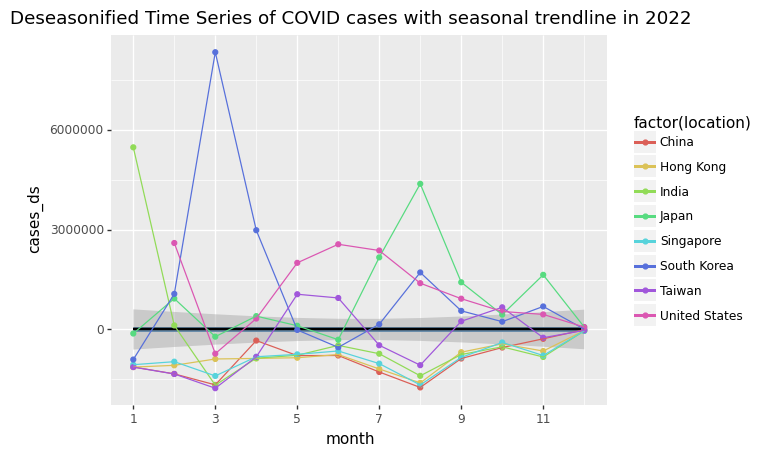

<ggplot: (121407383090)>

In [38]:
avg = stat_summary(aes(group=1), fun_y = np.mean, geom = "line", colour = "steelblue", size = 2, na_rm = True)
line = geom_smooth(aes(group=1), method='lm')
ggplot(countries_month, aes('month', 'cases_ds', group='location')) + avg + line + \
  ggtitle("Deseasonified Time Series of COVID cases with seasonal trendline in 2022") + geom_point(aes(color='factor(location)')) + geom_line(aes(color='factor(location)')) + scale_x_continuous(breaks = range(1,13,2))

After removing the obvious pattern, we can see there's a rise in China's residual new cases starting from August.

# 8. T test for the influence of Omicron vs the influence of "9th Edition"

Mainland China reported its first case of the **omicron** Covid variant on Dec 13, 2021. (https://www.cnbc.com/2021/12/14/mainland-china-reports-its-first-omicron-covid-case.html)

 **"Guidance for COVID-19 Control (9th Edition)"** is published on Jun 28, 2022 (http://www.gov.cn/xinwen/2022-06/29/content_5698473.htm)

In [39]:
def get_period(row):
  if row['date'] <= pd.Timestamp('2021-12-13'):
    return 'before omicron'
  elif row['date'] <= pd.Timestamp('2022-6-28'):
    return 'omicron, before 9th edition'
  else:
    return 'omicron, after 9th edition'

In [40]:
case['period'] = case.apply(lambda row:get_period(row), axis=1)
case.head()

,date,total,import,local,year,month,dayofweek,day,period
0,2022-12-07,4079,48,4031,2022,12,2,weekdays,"omicron, after 9th edition"
1,2022-12-06,4409,58,4351,2022,12,1,weekdays,"omicron, after 9th edition"
2,2022-12-05,5046,58,4988,2022,12,0,weekdays,"omicron, after 9th edition"
3,2022-12-04,4318,71,4247,2022,12,6,weekends,"omicron, after 9th edition"
4,2022-12-03,4213,45,4168,2022,12,5,weekends,"omicron, after 9th edition"


In [41]:
stats.ttest_ind(case[case['date'] > '2021-12-13']['total'], case[case['period']=='before omicron']['total'])

Ttest_indResult(statistic=13.251917056061068, pvalue=2.4797634017006744e-36)

In [42]:
stats.ttest_ind(case[case['date'] > '2021-12-13']['import'], case[case['period']=='before omicron']['import'])

Ttest_indResult(statistic=20.50117036200962, pvalue=3.440140753370568e-75)

Both p value << 0.05, both Null Hypotheses are rejected.
There **is** a significant difference in the **total** covid case between before and after China's first omicron case.
There **is** a significant difference in the **imported** covid case between before and after China's first omicron case.

In [43]:
stats.ttest_ind(case[case['period']=='omicron, before 9th edition']['total'], case[(case['period']=='omicron, after 9th edition')]['total'])

Ttest_indResult(statistic=-1.3789576760655198, pvalue=0.1687711350950561)

In [44]:
stats.ttest_ind(case[case['period']=='omicron, before 9th edition']['import'], case[(case['period']=='omicron, after 9th edition')]['import'])

Ttest_indResult(statistic=-2.6778173091489252, pvalue=0.007752735351322857)

The p value of total case is greater than 0.05; while the p value of imported case is smaller than 0.05
There **is not** a statistically significant difference in the **total** covid case between before and after "Guidance for COVID-19 Control (9th Edition)" was published.
However, there **is** a statistically significant difference in the **imported** covid case between before and after "Guidance for COVID-19 Control (9th Edition)" was published.

*Note: To control the variable, we only use the covid case data after China's first omicron case to analysis the influence of "9th edition"*

# 9. Jointplot of the imported and local cases before and after "9th edition"

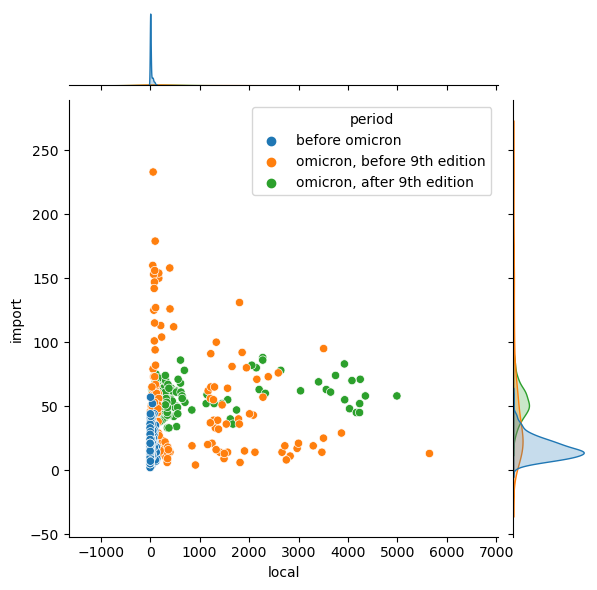

In [45]:
sns.jointplot(x='local',y='import',data=case, hue='period', hue_order=['before omicron','omicron, before 9th edition','omicron, after 9th edition'])